# Data Assimilation

In [1]:
import os
import numpy as np
import torch

from atlaswildfiretool.assimilation.data_assimilation import DataAssimilation
from atlaswildfiretool.assimilation.train_pca import TrainPCA
from atlaswildfiretool.assimilation.utils import (
    create_augmented_array,
    plot_matrix_with_condition_number,
    modify_image_array,
)
from atlaswildfiretool.assimilation.cnn import CNNAutoencoder
from atlaswildfiretool.assimilation.decompression import (
    PCADecompressor,
    CAEDecompressor,
)
from atlaswildfiretool.forecasting.model import ImageSequencePredictor
from atlaswildfiretool.forecasting.generate_images import generate

# 1. Prepare Augmented Data for calucating PCA, B and R


To improve the numerical stability of B and R matrix in latent space, data augmentation technique are applied to generated images and observations so that to improve the condition number of B and R.

### 1.1 Data Augmentation for LSTM

#### Observation Data
- Rotate Observation to generate more data.
#### Model Data
- Use LSTM to predict more time steps and then rotate them.
#### PCA Training Data
- Augmented Observation Data + Model Data

#### Data Loading
* A user will need to download the wildfire data available at `https://companyname.sharepoint.com/sites/projectname/Shared%20Documents/example-document.docx`
* the current set up runs given that the `.npy` wildfire data is stored in a `data/` DIR.

In [2]:
# Load observation data
obs = np.load("../../../Ferguson_fire_obs.npy")
ag_obs = create_augmented_array(obs)
model_data = np.load("../../../Ferguson_fire_obs_with_generated.npy")
# last 10 data are predicted data
ag_model_data = create_augmented_array(model_data[5:15])
# PCA training data
pca_train_data = create_augmented_array(model_data)
# save them into npy
np.save("../../../gen_obs_for_R_55.npy.npy", ag_obs)
np.save("../../../gen_obs_for_B_110.npy", ag_model_data)
np.save("../../../gen_obs_for_pca.npy", pca_train_data)

### 1.2 Data Augmentation for VAE

#### Observation Data
- Rotate Observations to generate more data.
#### Model Data
- Use VAE to generate more images and then rotate them.
#### PCA Training Data
- Augmented Observation Data + Model Data

In [3]:
# ask objective 2 to save the generated data in some place
gen_obs = np.load("../../../task2_top_background_images.npy").astype(np.float32)
gen_obs_for_pca = create_augmented_array(gen_obs)
np.save("../../../task2_top_background_100.npy", gen_obs_for_pca)

# 2.Train PCA model for LSTM and VAE

### 2.1 Train PCA for LSTM

In [ ]:
base_dir = (
    "/data" #assume all the data are stored in the data folder
)

In [5]:
# need to find a better solution
train_file = os.path.join(base_dir, "gen_obs_for_pca.npy")
obs_file = os.path.join(base_dir, "Ferguson_fire_obs.npy")
background_file = os.path.join(base_dir, "Ferguson_fire_background.npy")

MSE between the  0 th image of obsevation and background dataset in physic space: 0.0426483154296875
MSE between the  0 th image of obsevation and background dataset in physic space: 14.20864970748715


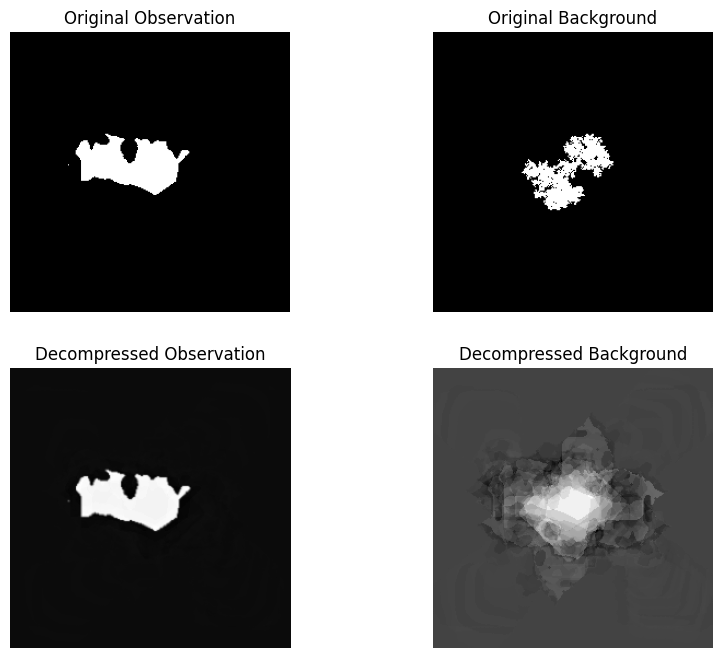

In [6]:
# train pca model for task1

pca_trainer = TrainPCA(
    train_file,
    obs_file,
    background_file,
    n_components=100,
    obs_index=0,
    background_index=0,
)

pca_trainer.print_mse()
pca_trainer.save_model("pca_model_task1.pkl")
obs_reduced, background_reduced = pca_trainer.get_reduced_data()
pca_trainer.plot_images()

### 2.2 Load CAE for VAE

In [10]:
test_file = os.path.join(base_dir, "Ferguson_fire_test.npy")
cnn_model_path = os.path.join(base_dir, "cnn_model.pth")
device = "cuda" if torch.cuda.is_available() else "cpu"

In [11]:
autoencoder = CNNAutoencoder(train_file, test_file, background_file, obs_file, device)
c_autoencoder_decompressor = CAEDecompressor(
    model_obj=autoencoder, model_path=cnn_model_path, device=device
)

# 3.Data Assimilation

### Data Assimilation Workflow

#### Setting up B and R Matrix
- The $\mathbf{B}$ and $\mathbf{R}$ matrices are error covariance matrices. We assume both of them are constant matrices, which means the measurement error do not change with time. The calucation of B is the covariance matrix of the model predicted(LSTM) or generated(VAE) images. R is the covariance matrix of oberservation image. Augmented historical data are used to better estimate numerically stable error covariance matrices. Although preferably, $\mathbf{B}$ and $\mathbf{R}$ should be calculated in the physical space, the huge image size makes the covariance matrix computation demanding. Therefore, we compress them into the latent space and calculate the covariance matrix there as the eigenvalues of the covariance matrix in the physical space, which indicate the variance along the principal components, are directly related to the variances in the latent space. The principal components (eigenvectors) align the data along axes of maximum variance, ensuring that the most critical variances are preserved during the dimensionality reduction. After checking the condition number of $\mathbf{B}$ and $\mathbf{R}$, we adjust the Regularization terms of $\mathbf{B}$ and $\mathbf{R}$ or approximate the covariance matrix to a diagonal form to improve the condition.

#### Regularization of B and R
- The regularization of $\mathbf{B}$ and $\mathbf{R}$ depends on their condition numbers. A matrix with a large condition number implies numerical instability and potential issues with trustworthiness. Higher values of regularization terms will be set to regularize the matrices.


#### Data Assimilation Method

- Our approach is partially an Ensemble Kalman Filter. We use augmented data to create an ensemble for the error covariance estimation. The reason it is only partially an Ensemble Kalman Filter is that we do not use the ensemble of images to predict the next states.

### 3.1 DA on LSTM prediciton using PCA

In [7]:
# Initialize the decompressor
PCA1 = PCADecompressor("pca_model_task1.pkl")
back_last_file = os.path.join(base_dir, "back_last.npy")
gen_obs_for_R_55_file = os.path.join(base_dir, "gen_obs_for_R_55.npy")
gen_obs_for_B_110_file = os.path.join(base_dir, "gen_obs_for_B_110.npy")

MSE (reduced before da): 3.8876059101877147
MSE (full before da): 0.0087738037109375
MSE (reduced after da): 1.4737337326745075
MSE (full after da): 0.0067291259765625


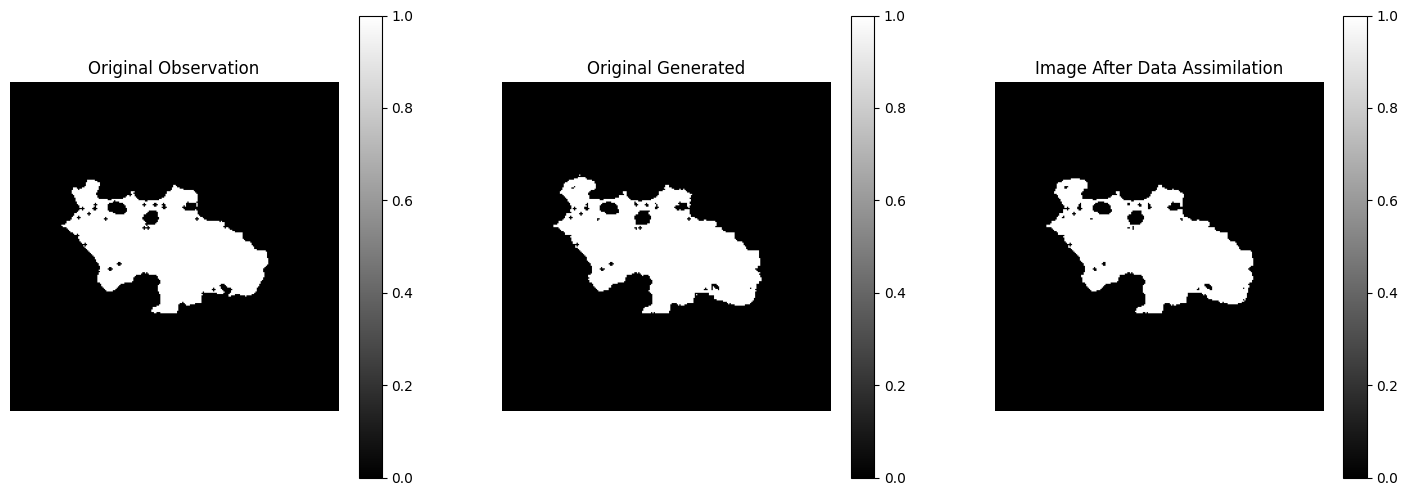

In [8]:
# apply data assimilation for result that from task1

da = DataAssimilation(
    back_last_file,
    PCA1,
    obs_file,
    gen_obs_for_R_55_file,
    gen_obs_for_B_110_file,
    obs_index=-1,
    W_B=1,
    W_R=1,
    latent_shape=100,
)
da.assimilate()
da.print_mse()
da.plot_images()

#### 3.1.1 Choice of weight terms of B and R

The condition number of the matrix is: 1518634611.8383856


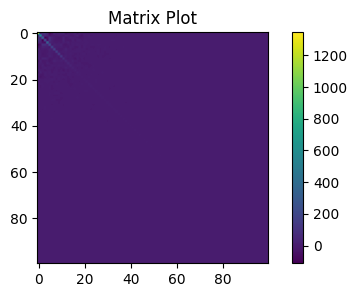

In [11]:
# show the condition number of the original cov matrix
plot_matrix_with_condition_number(da.B_0)

The condition number of the matrix is: 1237.9517224934773


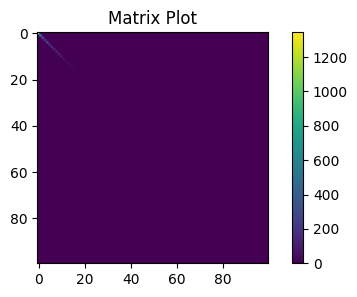

In [12]:
# show the condition number of the diag cov matrix
plot_matrix_with_condition_number(da.B)

The condition number of the matrix is: 3.0226242325961613e+19


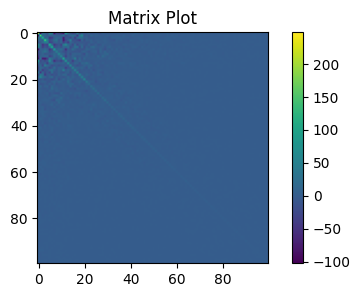

In [13]:
# show the condition number of the original cov matrix
plot_matrix_with_condition_number(da.R_0)

The condition number of the matrix is: 259.26906293803216


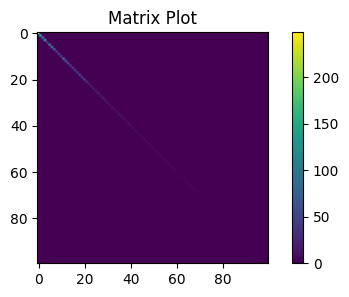

In [14]:
# show the condition number of the diag cov matrix
plot_matrix_with_condition_number(da.R)

 The B diag has a high condition number of approximately 1200, indicating potential numerical instability and sensitivity to perturbations. This is reflected in the graph, which shows large values concentrated in the diagonal, suggesting issues with scaling and accuracy. In contrast, the R diag matrix, with a reduced condition number of approximately 165, demonstrates enhanced numerical stability. The corresponding graph shows a more uniform distribution of values along the diagonal, indicating a more stable and reliable matrix. This improvement suggests that the second matrix is better conditioned, reducing the risk of numerical errors and improving the robustness of subsequent computations. Therefore, the weight of B and much higher than weight of R.

### 3.2 DA on VAE generated images compressed CAE

In [15]:
task2_best_background_assimilate_2_file = os.path.join(
    base_dir, "task2_best_background_assimilate.npy"
)
task2_top_background_100_file = os.path.join(base_dir, "task2_top_background_100.npy")

In [62]:
# due to the time limited, we will show the reuslt in our powerpoint
da = DataAssimilation(
    task2_best_background_assimilate_2_file,
    c_autoencoder_decompressor,
    obs_file,
    gen_obs_for_R_55_file,
    task2_top_background_100_file,
    obs_index=0,
    W_B=20,
    latent_shape=32768,
)

da.assimilate()
da.print_mse()
da.plot_obs_image()
da.plot_predicted_image()
da.plot_fixed_predicted_image()

## 3.3 Continuously correct LSTM predictions with DA(3 images predict 1)

#### Workflow
We aim to achieve two data assimilations over 5 timesteps. The workflow involves using our LSTM to predict the 4th image from the first 3 images. Then, we perform data assimilation to correct the prediction. We replace the 4th predicted image with the assimilated image. Finally, we predict the last image and perform data assimilation again

In [16]:
# create the model
input_dim = 64
hidden_dim = [128, 64]
kernel_size = (3, 3)
num_layers = 2

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Create model
model = ImageSequencePredictor(input_dim, hidden_dim, kernel_size, num_layers)
model.load_state_dict(torch.load("../../../model_epoch_1.pth", map_location=device))

<All keys matched successfully>

#### 3.3.1 First LSTM prediction on the 4th image

Test Mean Squared Error (MSE): 0.0005
Background Mean Squared Error (MSE): 0.0155
Obs Mean Squared Error (MSE): 0.0133


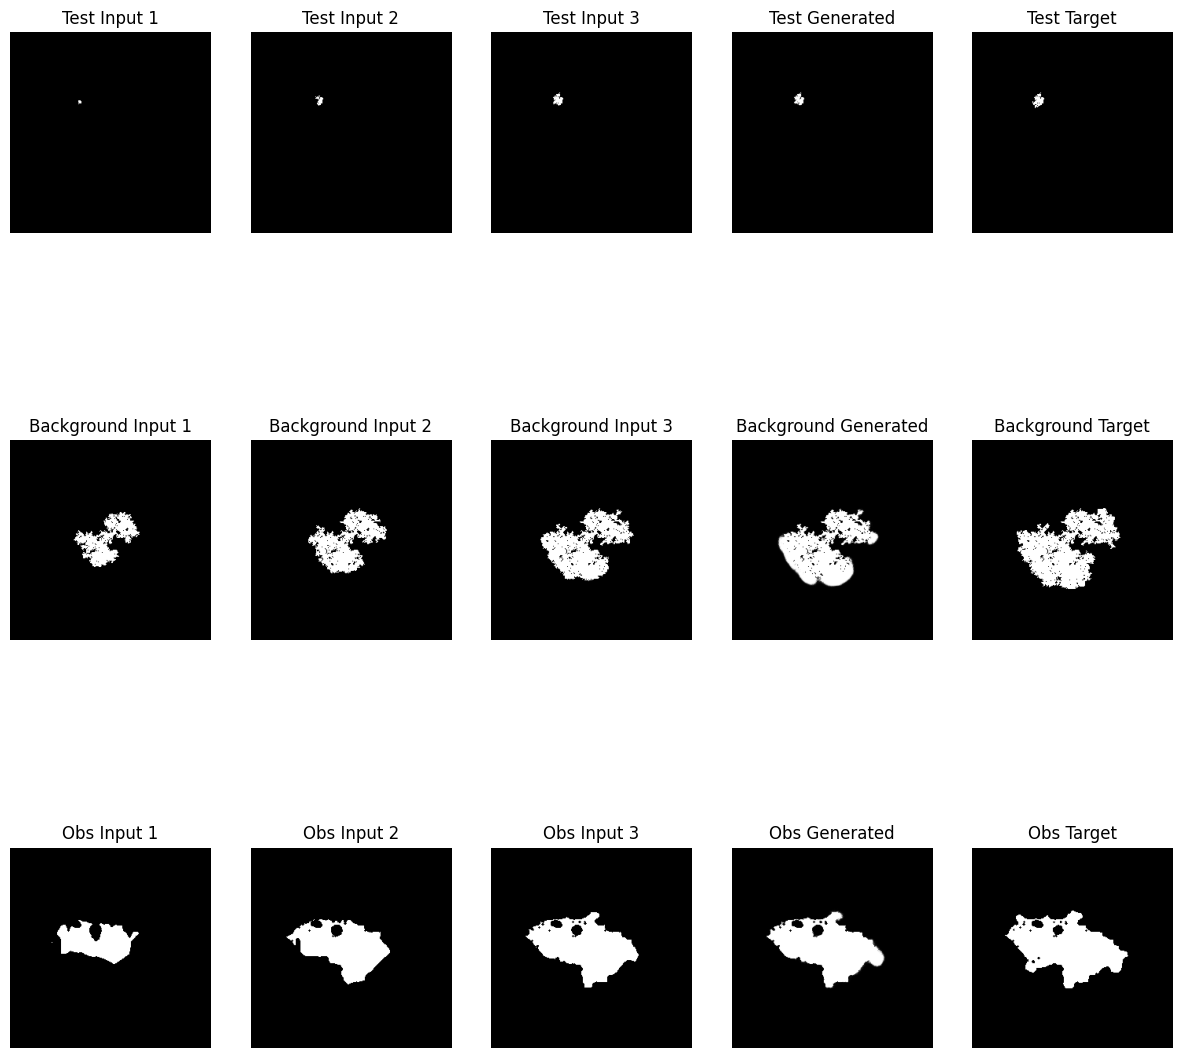

In [29]:
obs_data_0to4 = obs[0:4]
np.save("obs_data_0to4.npy", obs_data_0to4)
test_data = "../../../Ferguson_fire_test.npy"
background_data = "../../../Ferguson_fire_background.npy"
obs_data = "obs_data_0to4.npy"
start = 0
num_inputs = 3
output_obs = generate(
    model, test_data, background_data, obs_data, start, num_inputs, device
)
output_obs = np.array(output_obs)[-1]
np.save("../../../pred_4.npy", output_obs)

#### keypoint: 
- The 4th generated image is an underestimation of the actual image. The wildfire in the lower left corner never spread as furiously before, as it does between images 3 and 4. The LSTM cannot predict this spreading without data assimilation. Let's explore how data assimilation can help.

#### 3.3.2 First DA

MSE (reduced before da): 6.630800418946656
MSE (full before da): 0.013280986610112405
MSE (reduced after da): 0.055713036236813146
MSE (full after da): 0.0001678466796875


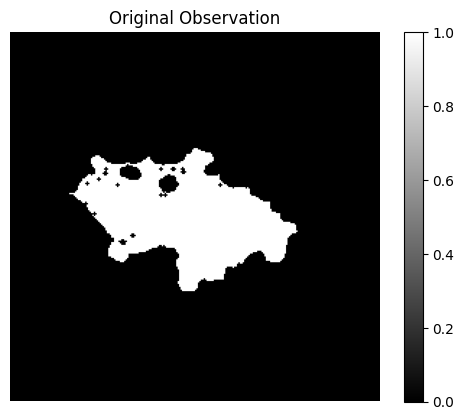

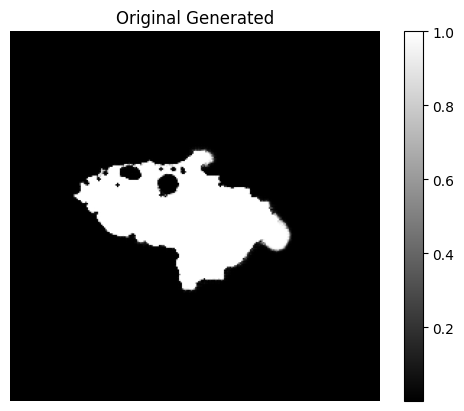

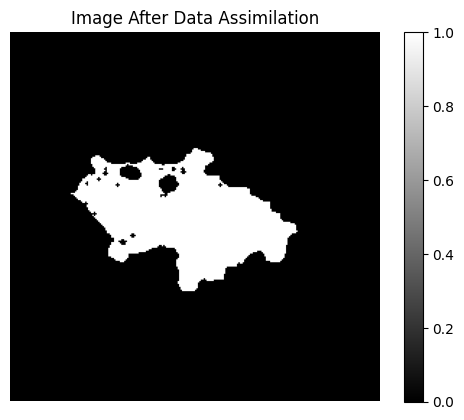

In [18]:
# Construct full file paths
pred_4_file = os.path.join(base_dir, "pred_4.npy")
gen_obs_for_B_110_file = os.path.join(base_dir, "gen_obs_for_B_110.npy")


da = DataAssimilation(
    pred_4_file,
    PCA1,
    obs_file,
    gen_obs_for_R_55_file,
    gen_obs_for_B_110_file,
    obs_index=3,
    W_B=20,
    latent_shape=100,
)
da.assimilate()
da.print_mse()
da.plot_obs_image()
da.plot_predicted_image()
da.plot_fixed_predicted_image()
da.save_predicted_image("../../../DA_image.npy")

Data assimilation (DA) can successfully correct both the overestimation and underestimation of the wildfire.

In [26]:
DA_image = np.load("DA_image.npy")
obs_2to5 = modify_image_array(obs_data_0to4, DA_image, obs[-1])
obs_2to5 = np.append(obs_2to5, np.expand_dims(DA_image, axis=0), axis=0)
np.save("../../../obs_2to5.npy", obs_2to5)

Test Mean Squared Error (MSE): 0.0005
Background Mean Squared Error (MSE): 0.0155
Obs Mean Squared Error (MSE): 0.0131


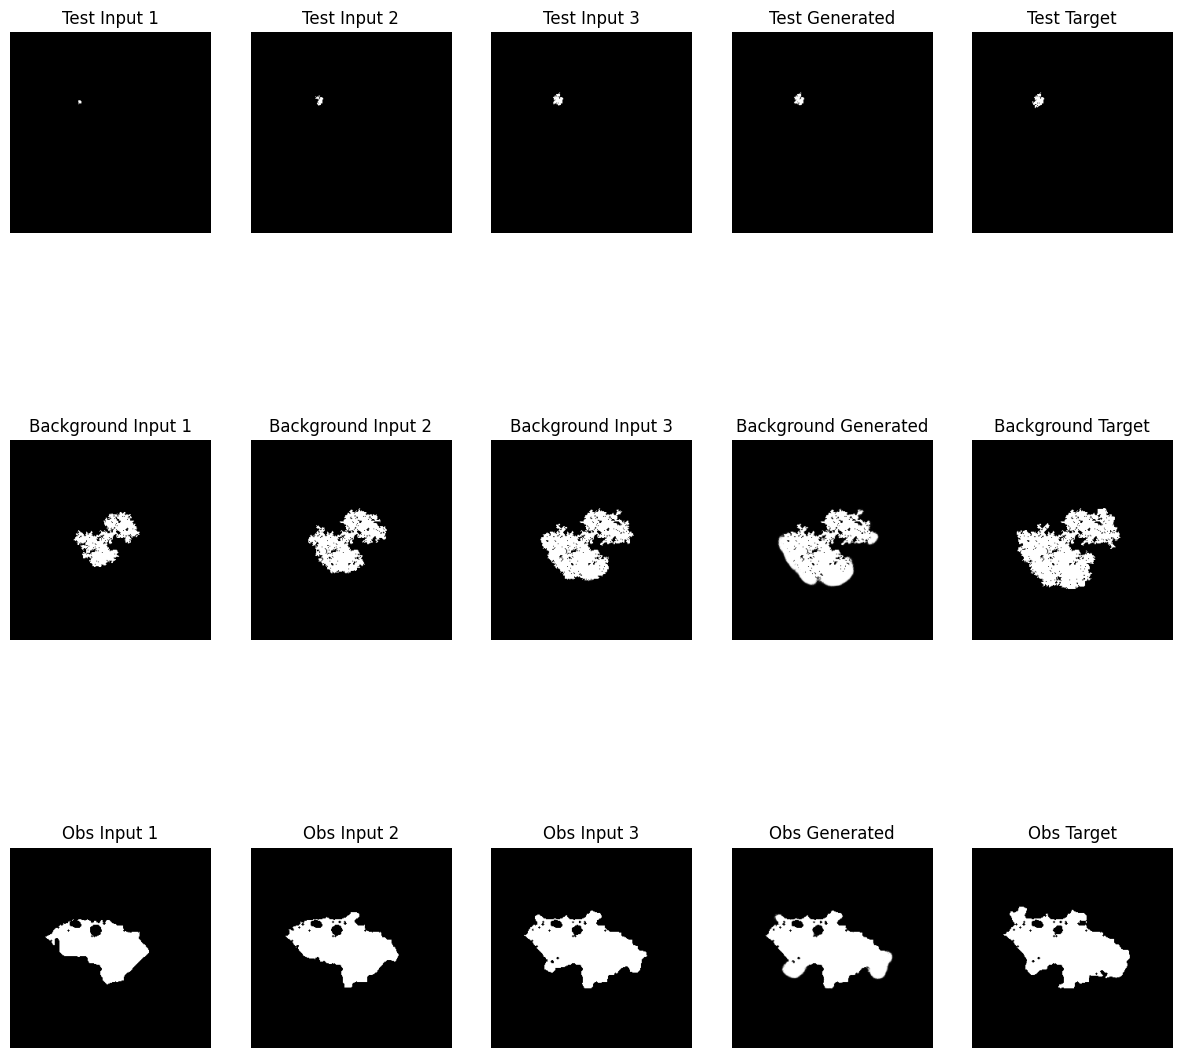

In [27]:
obs_2to5 = os.path.join(base_dir, "obs_2to5.npy")
output2 = generate(
    model, test_data, background_data, obs_2to5, start, num_inputs, device
)
np.save("../../../pred_5.npy", output2[-1])

#### 3.3.3 Second DA prediction to the 5th image

MSE (reduced before da): 2.720444329815465
MSE (full before da): 0.00907769247875873
MSE (reduced after da): 0.020191325363488714
MSE (full after da): 0.000244140625


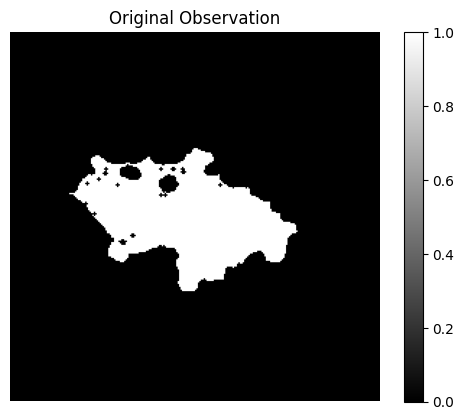

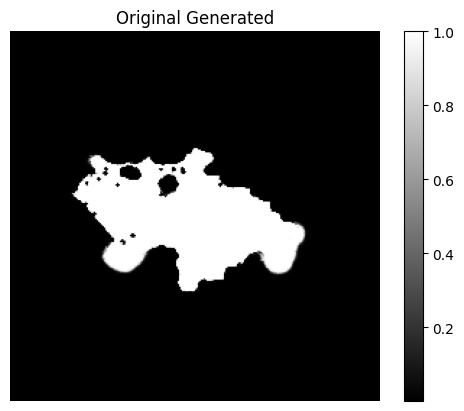

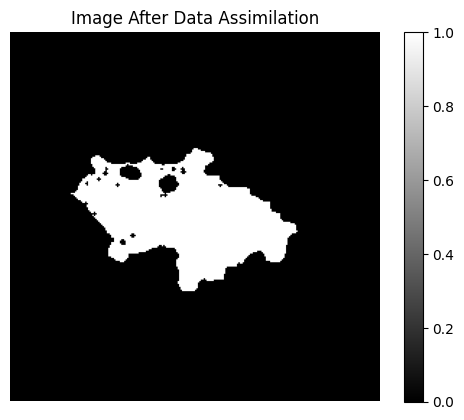

In [28]:
pred_5 = os.path.join(base_dir, "pred_5.npy") 
da = DataAssimilation(
    pred_5,
    PCA1,
    obs_file,
    gen_obs_for_R_55_file,
    gen_obs_for_B_110_file,
    obs_index=3,
    W_B=20,
    latent_shape=100,
)
da.assimilate()
da.print_mse()
da.plot_obs_image()
da.plot_predicted_image()
da.plot_fixed_predicted_image()
da.save_predicted_image("../../../DA2_image.npy")